## 在 sklearn 中使用 SVM
* 导入：from sklearn import svm
* SVM 即可以做回归，也可以做分类器
 * 回归：SVR 或 LinearSVR，Support Vector Regression。
 * 分类：SVC 或 LinearSVC，Support Vector Classification。
* 创建 SVM 分类器：构造函数：model = svm.SVC(kernal="rbf", C=1.0, gamma="auto")
 * kernal 核函数，默认为 rbf，即高斯核函数
    1. linear 线性核函数，**只**在数据线性可分的情况下使用，运算速度快，效果好。
    2. poly 多项式核函数，将数据从低维空间映射到高维空间，参数较多，计算量大。
    3. rbf 高斯核函数，映射到高维空间，较多项式核函数所需参数少，性能不错，默认使用。
    4. sigmoid sigmoid 核函数，实现多层神经网络。
 * C 目标函数的惩罚系数，分错样本时的惩罚程度，默认为 1.0
    1. C 越大，分类器准确率越高，容错率越低，泛化能力差。
    2. C 越小，泛化能力强，准确率降低。
 * gamma 核函数的系数，默认为样本特征数的倒数，即 gamma = 1 / n_features。
* model.fit(train_X, train_y)：传入特征值矩阵和分类标识，进行训练。
* prediction = model.predict(test_X)：进行预测，传入测试集中的样本特征矩阵。

*补充：LinearSVC 和 SCV 的差别*
* LinearSVC 线性分类器，用于处理线性可分的数据，只能用线性核函数。
* SVC 既可以用线性核函数（进行线性划分），也能用高维的核函数（进行非线性划分）。
* 不知道数据集是否为线性，可用 SVC 类创建，但对于数据量大的线性可分问题，LinearSVC 效率更高。

## 数据探索
*医疗人员采集了患者乳腺肿块经过细针穿刺后的数字化图像，并对这些数字化图像进行了特征提取，这些特征可以描述图像中的细胞核呈现。*

*肿瘤可分为良性和恶性*

**32个字段含义**
* mean 代表平均值
* se 代表标准差
* worst 代表最大值（3 个最大值的平均值）
* 每张图像计算了相应的特征，得出了 30 个特征值（不包括 ID 和 diagnosis），实际上是由 10 个特征值（radius、texture、perimeter、area、smoothness、compactness、concavity、concave points、symmetry 和 fractal_dimension_mean）的 3 个维度，平均值、标准差 和 最大值。
* 保留了 4 位数字。字段中无缺失值。
* 569 个患者中，357 良性，212 恶性。

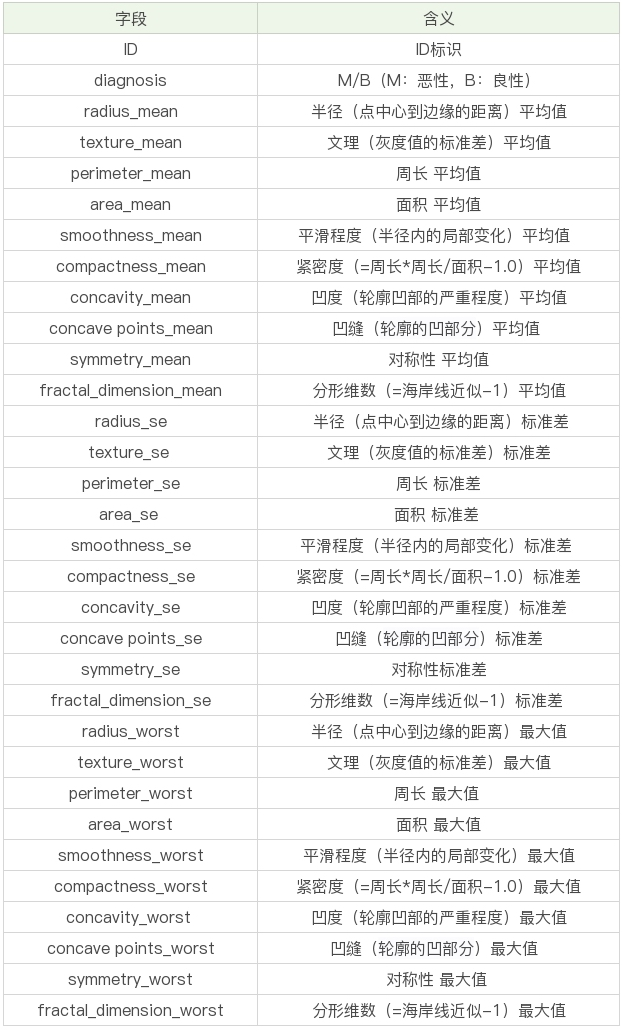

In [25]:
from IPython.display import Image

Image(filename="../img/乳腺癌数据特征含义.jpg")

## 数据探索
* 使用 pandas 加载数据
* 使用 pandas_profiling 对数据形成初始报告

In [26]:
import pandas as pd
import pandas_profiling

breast_cancer_data = pd.read_csv("data/breast_cancer_data.csv")

pandas_profiling.ProfileReport(breast_cancer_data)

In [27]:
import pandas as pd

breast_cancer_data = pd.read_csv("data/breast_cancer_data.csv")

# 因数据集中列较多，需将 dataframe 中的列全部显示
pd.set_option('display.max_columns', None)
print(breast_cancer_data.columns)
print(breast_cancer_data.head(5))
print(breast_cancer_data.describe())

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42

## 数据清洗
**32 个字段中**
* ID 无意义，去掉
* diagnosis 取值为 B 或 M，用 0 / 1 代替
* 其余 30 个字段分为 3 组，mean、se 和 worst 代表了每组字段不同的度量方式

In [28]:
# 特征字段分为 3 组
features_mean = list(breast_cancer_data.columns[2:12])
features_se = list(breast_cancer_data.columns[12:22])
features_worst = list(breast_cancer_data.columns[22:32])

# 数据清洗
# 去除 ID 列
breast_cancer_data.drop("id", axis=1, inplace=True)

# 将 B 良性替换为 0，M 恶性替换为 1
breast_cancer_data["diagnosis"] = breast_cancer_data["diagnosis"].map({"B":0, "M":1})

## 特征字段筛选
* 观察 feature_mean 各变量之间的关系：DataFrame 的 corr()，热力图可视化呈现。同时，可以看到整体良性、恶性肿瘤的诊断情况。

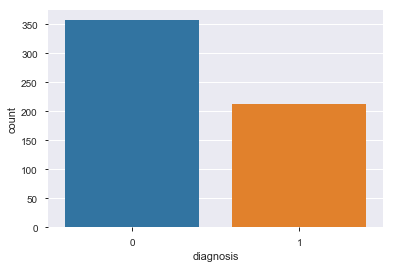

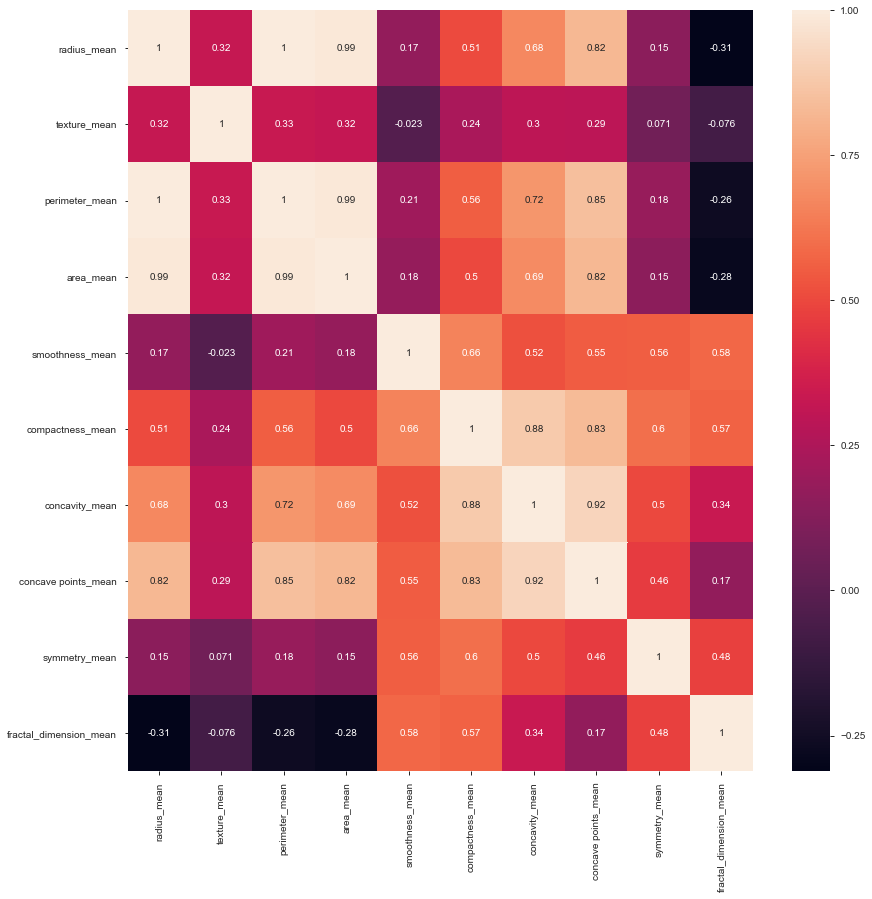

In [29]:
# 将肿瘤诊断结果可视化
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(breast_cancer_data["diagnosis"], label="Count")
plt.show()

# 用热力图呈现 features_mean 字段之间的相关性
corr = breast_cancer_data[features_mean].corr()
plt.figure(figsize=(14,14))

# annot=True 显示每个方格的数据
sns.heatmap(corr, annot=True)
plt.show()

**解释**
* 热力图中对角线上的为单变量自身的相关系数是 1，颜色越浅，相关性越大。
* radius_mean、perimeter_mean、area_mean 三个属性相关性大；compactness_mean、concavity_mean、concave points_mean 三个属性相关性大。
  * 从这两类中选择 1 个属性作为代表即可。
* 特征选择的目的是降维，用少量的特征代表数据的特性，增强分类器的泛化能力，避免过拟合。
* mean、se、worst 三个特征是对同一组内容的不同度量方式，这里采用 mean，忽略 se 和 worst。

In [30]:
# 特征选择
features_remain = ["radius_mean", "texture_mean", "smoothness_mean", "compactness_mean", "symmetry_mean", "fractal_dimension_mean"]

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 30% 作为测试集，其余为训练集
train, test = train_test_split(breast_cancer_data, test_size=0.3)

# 抽取特征选择的数值作为训练和测试数据
train_X = train[features_remain]
train_y = train["diagnosis"]
test_X = test[features_remain]
test_y = test["diagnosis"]

# 对数据进行规范化，让数据在同一量级上，避免因维度问题造成数据误差
# Z-Score 规范化数据，保证每个特征维度的数据均值为 0，方差为 1
ss = StandardScaler()
train_X = ss.fit_transform(train_X)
test_X = ss.transform(test_X)

## 使用 SVC 进行分类，计算准确率

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 创建 SVM 分类器
breast_cancer_model = SVC()

# 训练集做训练
breast_cancer_model.fit(train_X, train_y)

# 测试集做预测
prediction = breast_cancer_model.predict(test_X)

# 打印准确率
print("准确率: ", accuracy_score(prediction, test_y))

准确率:  0.9473684210526315


## 使用 LinearSVC 进行分类，计算准确率

In [33]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# 创建 SVM 分类器
breast_cancer_model = LinearSVC()

# 训练集做训练
breast_cancer_model.fit(train_X, train_y)

# 测试集做预测
prediction = breast_cancer_model.predict(test_X)

# 打印准确率
print("准确率: ", accuracy_score(prediction, test_y))

准确率:  0.9415204678362573
